# **0. Intro**

This notebook will predict the labels of test set with **convolutional neural network (CNN)** and **vision transformers (ViT)**, and compare the accuracy of these methods.

# **1. Convolutional Neural Network**

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

2024-07-21 07:11:02.192697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 07:11:02.192792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 07:11:02.318732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Make sure training with GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
num_gpus = len(gpus)
print("Num GPUs Available: ", num_gpus)

if num_gpus > 0:
    try:
        
        if num_gpus >= 2:
            tf.config.experimental.set_visible_devices(gpus[:2], 'GPU')
            strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
            print("Using 2 GPUs")
        else:
            
            tf.config.experimental.set_visible_devices(gpus, 'GPU')
            strategy = tf.distribute.MirroredStrategy()
            print(f"Using {num_gpus} GPU(s)")
    except RuntimeError as e:
        print(e)
else:
    
    strategy = tf.distribute.get_strategy()
    print("Using CPU")

Num GPUs Available:  2
Using 2 GPUs


## Load Train and Validation Sets

In [3]:
# Path
train_input_dir = "/kaggle/input/nzmsa-2024/cifar10_images/train"
csv_file = "/kaggle/input/nzmsa-2024/train.csv"

train_output_dir = "/kaggle/working/data/train"
val_output_dir = "/kaggle/working/data/val"

In [4]:
# Load train csv
df = pd.read_csv(csv_file)

In [5]:
# Create train and val folders
for label in range(10):
    os.makedirs(os.path.join(train_output_dir, str(label)), exist_ok=True)
    os.makedirs(os.path.join(val_output_dir, str(label)), exist_ok=True)

In [6]:
# Copy images to train and val folders
for label in range(10):
    label_df = df[df['label'] == label]
    train_images = label_df['id'].tolist()[:4500]
    val_images = label_df['id'].tolist()[4500:5000]

    # Copy train images
    for img_id in train_images:
        src_path = os.path.join(train_input_dir, f"image_{img_id}.png")
        dest_path = os.path.join(train_output_dir, str(label), f"image_{img_id}.png")
        shutil.copy(src_path, dest_path)

    # Copy val images
    for img_id in val_images:
        src_path = os.path.join(train_input_dir, f"image_{img_id}.png")
        dest_path = os.path.join(val_output_dir, str(label), f"image_{img_id}.png")
        shutil.copy(src_path, dest_path)

print("Train and Val images copied")

Train and Val images copied


In [7]:
# Check files in folders
output_dir = val_output_dir

for label in range(10):
    label_dir = os.path.join(output_dir, str(label))
    num_files = len(os.listdir(label_dir))
    print(f"Folder {label} has {num_files} images.")

Folder 0 has 500 images.
Folder 1 has 500 images.
Folder 2 has 500 images.
Folder 3 has 500 images.
Folder 4 has 500 images.
Folder 5 has 500 images.
Folder 6 has 500 images.
Folder 7 has 500 images.
Folder 8 has 500 images.
Folder 9 has 500 images.


## Load Test Set

In [8]:
# Create test folder
test_input_dir= '/kaggle/input/nzmsa-2024/cifar10_images/test'
test_output_dir = "/kaggle/working/data/test"
os.makedirs(test_output_dir)

In [9]:
# Copy test images into labelled folders
for filename in os.listdir(test_input_dir):
    src_path = os.path.join(test_input_dir, filename)
    dst_path = os.path.join(test_output_dir, filename)
    shutil.copy(src_path, dst_path)

print("Test images copied")

Test images copied


In [10]:
# Display number of images in test folder
num_files = len(os.listdir(test_output_dir))
print(f"Folder {test_output_dir} has {num_files} images.")

Folder /kaggle/working/data/test has 5000 images.


In [11]:
print(train_output_dir)
print(val_output_dir)
print(test_output_dir)

/kaggle/working/data/train
/kaggle/working/data/val
/kaggle/working/data/test


## Process Train and Val Sets

In [12]:
# Process train and val set
IMG_WIDTH = 32
IMG_HEIGHT = 32
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_output_dir,  # Train set path
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    val_output_dir,  # Val set path
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


## Creat CNN Model

In [13]:
# Create cnn model
def create_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=512, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        BatchNormalization(),
        
        Dense(units=10, activation='softmax')
    ])
    
    return model

In [14]:
cnn_model = create_model()

cnn_model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimizer = Adam(learning_rate=0.0005)

cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,682 (4.02 MB)

 Trainable params: 1,050,506 (4.01 MB)

 Non-trainable params: 2,176 (8.50 KB)

## Train Model

In [15]:
# Train model and use val set for validation
history = cnn_model.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator,
    verbose=2,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721546357.031115      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721546357.056337      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721546365.719145      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721546412.932411      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1407/1407 - 69s - 49ms/step - accuracy: 0.3273 - loss: 2.0457 - val_accuracy: 0.4342 - val_loss: 1.6219 - learning_rate: 5.0000e-04
Epoch 2/100


W0000 00:00:1721546415.410450      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1407/1407 - 52s - 37ms/step - accuracy: 0.4609 - loss: 1.6241 - val_accuracy: 0.2364 - val_loss: 2.5725 - learning_rate: 5.0000e-04
Epoch 3/100
1407/1407 - 52s - 37ms/step - accuracy: 0.5302 - loss: 1.4507 - val_accuracy: 0.4976 - val_loss: 1.6272 - learning_rate: 5.0000e-04
Epoch 4/100
1407/1407 - 53s - 38ms/step - accuracy: 0.5786 - loss: 1.3348 - val_accuracy: 0.6478 - val_loss: 1.1093 - learning_rate: 5.0000e-04
Epoch 5/100
1407/1407 - 52s - 37ms/step - accuracy: 0.6115 - loss: 1.2470 - val_accuracy: 0.4574 - val_loss: 2.0933 - learning_rate: 5.0000e-04
Epoch 6/100
1407/1407 - 52s - 37ms/step - accuracy: 0.6382 - loss: 1.1970 - val_accuracy: 0.5446 - val_loss: 1.4212 - learning_rate: 5.0000e-04
Epoch 7/100
1407/1407 - 52s - 37ms/step - accuracy: 0.6506 - loss: 1.1580 - val_accuracy: 0.6874 - val_loss: 1.0739 - learning_rate: 5.0000e-04
Epoch 8/100
1407/1407 - 52s - 37ms/step - accuracy: 0.6623 - loss: 1.1359 - val_accuracy: 0.5752 - val_loss: 1.4168 - learning_rate: 5.0000e-04
Epoc

## Predict on Val Set

In [16]:
# Make prediction
predictions = cnn_model.predict(validation_generator)

 16/157 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

W0000 00:00:1721550996.627107      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


W0000 00:00:1721550998.896602      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
# Accuracy
val_loss, val_accuracy = cnn_model.evaluate(validation_generator, batch_size=BATCH_SIZE)
print(f"Val Loss:     {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8577 - loss: 0.5704
Val Loss:     0.5531666874885559
Val Accuracy: 0.8658000230789185


In [18]:
# Prepare true and prediction values
validation_generator.reset()
Y_pred = cnn_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


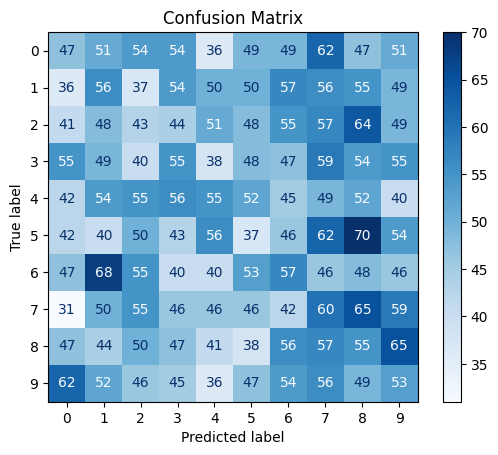

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# **2. Vision Transformers**

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datasets import Dataset, Array3D, ClassLabel, Features, load_dataset
from PIL import Image

import torch
import torch.nn as nn
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from transformers import AdamW, ViTFeatureExtractor, ViTModel

from sklearn.metrics import confusion_matrix

In [ ]:
# Make sure training with GPU
num_gpus = torch.cuda.device_count()
print(f"Num GPUs Available: {num_gpus}")

if num_gpus >= 2:
    device = torch.device("cuda:0")
    device_ids = [0, 1]
    print("Using 2 GPUs")
elif num_gpus == 1:
    device = torch.device("cuda:0")
    device_ids = [0]
    print("Using 1 GPU")
else:
    device = torch.device("cpu")
    device_ids = []
    print("Using CPU")

Num GPUs Available: 2
Using 2 GPUs


## Load Train and Validation Set

In [ ]:
# Use train folder for train and val set
train_folder = '/kaggle/input/nzmsa-2024/cifar10_images/train'
train_csv = '/kaggle/input/nzmsa-2024/train.csv'
train_df = pd.read_csv(train_csv)

In [ ]:
# Load images and labels
def load_image(image_id, folder):
    image_path = os.path.join(folder, f'image_{image_id}.png')
    image = Image.open(image_path).convert('RGB')
    return np.array(image)

In [ ]:
# Create dict for train and val
data = {
    'img': [load_image(i, train_folder) for i in train_df['id'][:15000,]],
    'label': train_df['label'][:15000,].tolist()
}

In [ ]:
# Dateset instance for train and val
dataset = Dataset.from_dict(data)
dataset

Dataset({
    features: ['img', 'label'],
    num_rows: 15000
})

In [ ]:
# Split train and val
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

## Load Test Set

In [ ]:
# Test folder
test_folder = '/kaggle/input/nzmsa-2024/cifar10_images/test'

In [ ]:
test_data = {
    'img': [load_image(i, test_folder) for i in range(5000)],
    'label': [0] * 5000
}

In [ ]:
# Dateset instance for test
test_ds = Dataset.from_dict(test_data)

In [ ]:
# Check train, val, test set
print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['img', 'label'],
    num_rows: 13500
})
Dataset({
    features: ['img', 'label'],
    num_rows: 1500
})
Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})


## Process Image

In [ ]:
# Use ViTFeatureExtractor to extract features, rescale and normalize images 
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


(32, 32, 3)
1


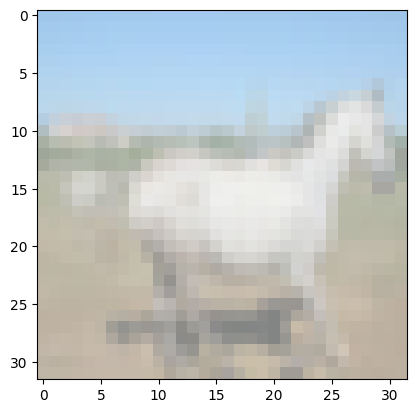

In [ ]:
chk = train_ds[67]
a = np.array(chk['img'])
print(a.shape)
cats = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


print(cats[chk['label']])
pyplot.imshow(a, cmap=pyplot.get_cmap('gray'))

In [ ]:
# Preprocess images function, get ready for training
def preprocess_images(examples):
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']
    return examples

In [ ]:
# Use HuggingFace Datasets map function to apply preprocess images function on dataset

# Define features
features = Features({
    'img': Array3D(dtype="uint8", shape=(32, 32, 3)),
    'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

# Preprocess datasets
preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, features=features)
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)

Map:   0%|          | 0/13500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
# Set format to PyTorch
preprocessed_train_ds.set_format('torch', columns=['pixel_values', 'label'])
preprocessed_val_ds.set_format('torch', columns=['pixel_values', 'label'])
preprocessed_test_ds.set_format('torch', columns=['pixel_values', 'label'])

## Create ViT Model

In [ ]:
# create dataloaders
train_batch_size = 10
eval_batch_size = 10
train_dataloader = torch.utils.data.DataLoader(preprocessed_train_ds, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(preprocessed_val_ds, batch_size=eval_batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(preprocessed_test_ds, batch_size=eval_batch_size, num_workers=2)
batch = next(iter(train_dataloader))

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
for param in vit_model.parameters():
      param.requires_grad = False

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=10):
        super(ViTForImageClassification, self).__init__()
        self.vit = vit_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits

In [ ]:
model = ViTForImageClassification()
model = model.to(device)

In [ ]:
# Compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(preprocessed_train_ds['label']), y=preprocessed_train_ds['label'].tolist())

# Convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# Loss function
cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [ ]:
# Optimizer
optimizer= AdamW(model.parameters(), lr = 1e-3)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train ViT Model

In [ ]:
# number of training epochs
epochs = 50

# function to train the model
def train():
  
    model.train()
    total_loss = 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
        
        # push the batch to gpu
        lbl, pix = batch.items()
        lbl, pix = lbl[1].to(device), pix[1].to(device)
        
        # get model predictions for the current batch
        preds = model(pix)
       
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, lbl)
        
        # add on to the total loss
        total_loss = total_loss + loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        
        # clear calculated gradients
        optimizer.zero_grad()  
        preds=preds.detach().cpu().numpy()
        
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    total_preds  = np.concatenate(total_preds, axis=0)
    
    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
def eval():
    total_loss = 0
    model.eval() # prep model for evaluation
    for step,batch in enumerate(val_dataloader):
        lbl, pix = batch.items()
        lbl, pix = lbl[1].to(device), pix[1].to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        preds = model(pix)
        # calculate the loss
        loss = cross_entropy(preds, lbl)
        total_loss += loss.item()
    
    return total_loss / len(val_dataloader)

In [ ]:
min_loss = inf
es = 0
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    val_loss = eval()
    
    # Early Stopping
    if val_loss < min_loss:
        min_loss = val_loss
        es = 0
    else:
        es += 1
        if es > 4:
            print("Early stopping with train_loss: ", train_loss, "and val_loss for this epoch: ", val_loss, "...")
            break
    
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\n Training Loss: {train_loss:.3f}')
    print(f'\n Validation Loss: {val_loss:.3f}')


 Epoch 1 / 50


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    50  of  1,350.
  Batch   100  of  1,350.
  Batch   150  of  1,350.
  Batch   200  of  1,350.
  Batch   250  of  1,350.
  Batch   300  of  1,350.
  Batch   350  of  1,350.
  Batch   400  of  1,350.
  Batch   450  of  1,350.
  Batch   500  of  1,350.
  Batch   550  of  1,350.
  Batch   600  of  1,350.
  Batch   650  of  1,350.
  Batch   700  of  1,350.
  Batch   750  of  1,350.
  Batch   800  of  1,350.
  Batch   850  of  1,350.
  Batch   900  of  1,350.
  Batch   950  of  1,350.
  Batch 1,000  of  1,350.
  Batch 1,050  of  1,350.
  Batch 1,100  of  1,350.
  Batch 1,150  of  1,350.
  Batch 1,200  of  1,350.
  Batch 1,250  of  1,350.
  Batch 1,300  of  1,350.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



 Training Loss: 0.468

 Validation Loss: 0.283

 Epoch 2 / 50
  Batch    50  of  1,350.
  Batch   100  of  1,350.
  Batch   150  of  1,350.
  Batch   200  of  1,350.
  Batch   250  of  1,350.
  Batch   300  of  1,350.
  Batch   350  of  1,350.
  Batch   400  of  1,350.
  Batch   450  of  1,350.
  Batch   500  of  1,350.
  Batch   550  of  1,350.
  Batch   600  of  1,350.
  Batch   650  of  1,350.
  Batch   700  of  1,350.
  Batch   750  of  1,350.
  Batch   800  of  1,350.
  Batch   850  of  1,350.
  Batch   900  of  1,350.
  Batch   950  of  1,350.
  Batch 1,000  of  1,350.
  Batch 1,050  of  1,350.
  Batch 1,100  of  1,350.
  Batch 1,150  of  1,350.
  Batch 1,200  of  1,350.
  Batch 1,250  of  1,350.
  Batch 1,300  of  1,350.

 Training Loss: 0.251

 Validation Loss: 0.255

 Epoch 3 / 50
  Batch    50  of  1,350.
  Batch   100  of  1,350.
  Batch   150  of  1,350.
  Batch   200  of  1,350.
  Batch   250  of  1,350.
  Batch   300  of  1,350.
  Batch   350  of  1,350.
  Batch   400  o

## ViT Predict on Val Set

In [ ]:
def dataset_eval(dataloader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for step, batch in tqdm(enumerate(dataloader), total = len(dataloader)):
            lbl, pix = batch.items()
            lbl, pix = lbl[1].to(device), pix[1].to(device)

            outputs = model(pix)
            outputs = torch.argmax(outputs, axis=1)
            y_pred.extend(outputs.cpu().detach().numpy())
            y_true.extend(lbl.cpu().detach().numpy())
            
    return y_pred, y_true

In [ ]:
y_pred, y_true = dataset_eval(val_dataloader)
correct = np.array(y_pred) == np.array(y_true)
vit_val_accuracy = correct.sum() / len(correct)
print("Accuracy of the model", vit_val_accuracy)

100%|██████████| 150/150 [00:17<00:00,  8.81it/s]

Accuracy of the model 0.92


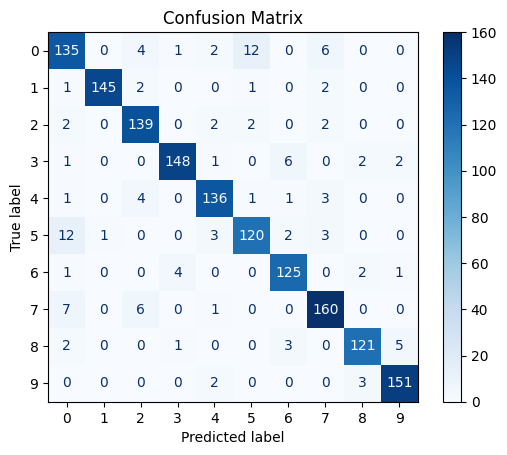

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# **3. Compare and Choose Method**

In [52]:
print(f"CNN Accuracy on Val: {val_accuracy}")
print(f"ViT Accuracy on Val: {vit_val_accuracy}")

CNN Accuracy on Val: 0.8658000230789185
ViT Accuracy on Val: 0.92
